In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

* Thermal energy confinement time: $\tau_{E,th} = W_{th}/P_{l,th}$ [s]
    - Thermal stored energy: $W_{th}$
* Intercept of the regression: $\alpha_0$    
* Plasma current: $I_P$ [MA]
* Vacuum toroidal magnetic field: $B_t$ [T]
* Central line-averaged electron density: $\bar{n}_e$ [$\cdot$10$^{19}$ m $^{-3}$] 
* Thermal power lost due to the transport through the LCFS: $P_{l,th}$ [MW]
* Major radius: $R_{geo}$ [m]
* Elongation of the last-closed flux surface: $\kappa = V/(2\pi R_{geo}\pi a^2)$ 
    - Plasma volume inside the LCFS: V [m$^{3}$]
    - Minor radius: $a$ [m] 
* Inverse aspect ration: $\epsilon = a/R_{geo}$ 
    - large $\epsilon$ = spherical tokamak (NSTX and MAST)
* Effective atomic mass of the plasma $M_{eff}$

$$
    \tau_{E,th} = \alpha_0\cdot I_P^{\alpha_I}\cdot B^{\alpha_B}_t\cdot \bar{n}^{\alpha_n}_e  \cdot P^{\alpha_P}_{l,th}\cdot R^{\alpha_R}_{geo}\cdot \kappa^{\alpha_\kappa}_a\cdot \epsilon^{\alpha_\epsilon}\cdot M^{\alpha_M}_{eff}
$$

In [2]:
DB2P8 = pd.read_csv("data/DB2P8.csv")
DB5 = pd.read_csv("data/DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv("data/new_point_ids.csv")

data = pd.read_csv("data/data.csv")
                  
Re_DB5 = pd.read_csv("data/R.csv")#DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

In [3]:
len(DB5.id.unique()),len(DB5)

(6250, 6250)

In [4]:
len(DB2P8.id.unique()),len(DB2P8)

(1310, 1310)

In [5]:
Y = DB2P8[["TAUTH"]].apply(np.log).to_numpy()

# Adding a column for the intercept
x_df = DB2P8[coeffs].apply(np.abs).apply(np.log)
x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
X = x_df.to_numpy()

$\hat{\beta} = (X^TX)^{-1}X^TY$;  $\qquad H = X(X^TX)^{-1}X^T $

In [17]:
B = np.matmul( np.linalg.inv( np.matmul(X.T,X) ) ,  np.matmul(X.T,Y))
B

array([[-3.00427156],
       [ 0.78118806],
       [ 0.32007666],
       [ 0.4351609 ],
       [-0.66818611],
       [ 2.22296166],
       [ 0.39007376],
       [ 0.57561255],
       [ 0.17980018]])

Leverage of the $i$-th case: the diagonal element of the hat matrix

$h_{ii} = x^T_i(X^TX)^{-1}x_i$ 

The residuals: $E = Y- \hat{\beta}X$

MSE: $s^2 = \sum^n_{i=1}\frac{E^2_i}{n-p}$

Studentized residual $r_i = E_i/s_{e_i}$

$$
    s_{e_i} = \sqrt{s^2(1-h_{ii})} \:\: \rightarrow \:\: r^*_i = \frac{e_i}{s(i)\sqrt{1-h_{ii}}}
$$

With $s^2(i)$ is the mean squared error when the $i-th$ case is omitted in fitting the regressio function. This follows the t-distribution with $n-p-1$ degrees of freedom; with assumptions.

In [7]:
E = Y - np.matmul(X,B)
E

array([[ 0.14691444],
       [ 0.17744197],
       [ 0.08069352],
       ...,
       [-0.20543691],
       [-0.14763166],
       [-0.13609172]])

---

### How does it change with DB5?

`pd.concat([df1, df2], axis=0, ignore_index=True)`

In [8]:
# Getting both DataFrames together

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

R = Re_DB5[["TAUTH"] + coeffs + ["id"]] 

complete_data = pd.concat([DB2, R], axis=0, ignore_index=True)
complete_data

,TAUTH,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,id
0,-2.975930,-1.217734,0.790728,1.332102,0.625938,0.527093,-0.025523,-1.418447,0.405465,HDULEH
1,-3.015527,-1.220102,0.790728,1.317480,0.705076,0.521172,-0.027988,-1.409604,0.405465,NAC6N1
2,-2.752786,-1.213686,0.790728,1.226712,0.123986,0.526502,-0.010556,-1.432100,0.405465,U2T1C7
3,-2.660547,-1.217734,0.790728,1.328400,0.319181,0.526502,-0.025933,-1.417369,0.405465,422XQB
4,-2.965979,-1.223495,0.790274,1.347294,0.709513,0.521766,-0.031387,-1.406800,0.405465,WZ9FED
...,...,...,...,...,...,...,...,...,...,...
6247,-4.094745,-1.515037,0.674474,1.593105,-0.486946,-0.189467,0.102557,-1.347185,0.693147,NGC85H
6248,-4.068677,-1.514582,0.668854,1.631004,-0.452871,-0.179605,0.096219,-1.354725,0.693147,ID1IP4
6249,-3.671826,-1.515037,0.668342,1.674664,-0.977634,-0.180324,0.098034,-1.355399,0.693147,K19A5H
6250,-1.753886,-0.020815,1.567574,1.252763,1.631591,0.897719,-0.000300,-1.116746,0.693147,D26CA1


In [9]:
Y_DB5 = complete_data[["TAUTH"]].to_numpy()

# Adding a column for the intercept
x_df = complete_data[coeffs]
x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
X_DB5 = x_df.to_numpy()

n, p = X_DB5.shape

B_DB5 = np.matmul( np.linalg.inv( np.matmul(X_DB5.T, X_DB5) ) ,  np.matmul(X_DB5.T, Y_DB5))
B_DB5

array([[-2.51853114],
       [ 1.13432954],
       [ 0.0723885 ],
       [ 0.17489654],
       [-0.6827009 ],
       [ 1.44790891],
       [ 0.28022651],
       [ 0.06355416],
       [ 0.21401782]])

# Why has $\alpha_R$ decreased?

## DFBETA

This is the parameter estimate after deleting the $i$-th observation; namely

$$
    \text{DFBETA} = \hat{\beta} - \hat{\beta}_i = \frac{X^TXx_iE_i}{1 - h_{ii}}
$$

with $C = (X^TX)^{-1}X^T$. If the x's are uniformly distributed then $c_{ij} = \mathcal{O}(n^{-1})$. The DFBETA$_j$ vector is 

$$
    \text{DFBETA}_j = b_j - b_{ji} = \frac{c_{ji}E_i}{1 - h_{ii}}
$$


With $j=1,\ldots,p$ and $b_j$ being the $j$-th element of the $\hat{\beta}$ parameter. When studying relative to the parameters, a scaled measure of the change can be done by 

$$
    \text{DFBETAS}_{ij} = \frac{b_j - b_{ji}}{s(i)\sqrt{(X^TX)^{-1}_{jj}}} = \frac{c_{ij}}{\sqrt{\sum_{k=1}^n c^2_{ij}}}\cdot\frac{r^*_i}{\sqrt{1-h_{ii}}}
$$

The denominator of DFBETAS$_{ij}$ is similar to the estimated standard deviation of $\hat{\beta}$ with the sample standard error $s$ replaced by the deleted-one version $s(i)$. BKW proposed a cutoff: $2\cdot n ^{-1/2}$


In [10]:
#H = np.matmul(np.matmul( X_DB5,  np.linalg.inv( np.matmul(X_DB5.T, X_DB5) )),  X_DB5.T)

residuals = Y_DB5 - np.matmul(X_DB5, B_DB5)
red_sqr = np.dot(residuals.T,residuals)[0][0]
S_sqr = red_sqr / (n-p)

In [21]:
def compute_OLS_alphaR_s2(data):
    y = data[["TAUTH"]].to_numpy()

    # Adding a column for the intercept
    x_df = data[coeffs]
    x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
    x = x_df.to_numpy()

    b = np.matmul( np.linalg.inv( np.matmul(X_DB5.T, X_DB5) ) ,  np.matmul(X_DB5.T, Y_DB5))
    # obtaining the bj from the parameter of interest
    alpha_R = b[5][0] 
    
    N, P = x.shape
    
    residuals = y - np.matmul(x, b)
    red_sqr = np.dot(residuals.T,residuals)[0][0]
    s = np.sqrt(red_sqr / (N-P))  # standard error
    
    return alpha_R, s

In [22]:
b_ji, s_i = np.zeros(len(R)), np.zeros(len(R))

for i in range(len(R)):
    df = complete_data[~complete_data.id.isin( [R["id"].loc[i]] )]
    b_ji[i], s_i[i] = compute_OLS_alphaR_s2(df)

In [27]:
db_betas_threshold = 2/np.sqrt(n)

DFBETA_j = ( B_DB5[5][0] - b_ji ) / ( s_i * np.sqrt( np.linalg.inv(np.matmul(X.T, X))[5][5] ) )

pts_added_DB5 = list(range(1,len(R) + 1))

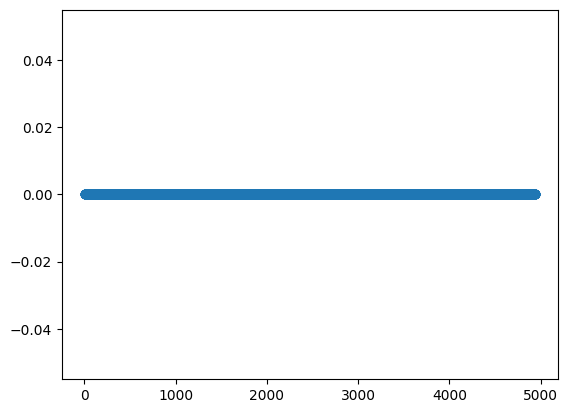

In [36]:
plt.scatter( pts_added_DB5, DFBETA_j  );

In [30]:
DFBETA_j

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
s_i

array([0.20170816, 0.20172389, 0.20172265, ..., 0.20169821, 0.20171289,
       0.2017051 ])

In [32]:
 np.sqrt( np.linalg.inv(np.matmul(X.T, X))[5][5] ) 

0.3154307378720393

In [35]:
B_DB5[5][0] 

1.4479089086806756

In [34]:
b_ji

array([1.44790891, 1.44790891, 1.44790891, ..., 1.44790891, 1.44790891,
       1.44790891])